<a href="https://colab.research.google.com/github/amirlevy1170/ML_homework/blob/main/ML3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this exercise we will optimize the log loss defined
as follows:

ℓlog (w, x, y) = log
1 + e
−yw·x

in the lecture you defined the loss with log2(·), but for optimization purposes the logarithm base doesn’t matter. Derive the gradient update for this case, and implement
the appropriate SGD function

In [1]:
import math
import random

import numpy as np
import numpy.random
import scipy.special
from sklearn.datasets import fetch_openml
import sklearn.preprocessing
import matplotlib.pyplot as plt


The helper function reads the examples labelled 0, 8 and returns them with the labels −1/+1.

In [2]:
def helper():
    mnist = fetch_openml('mnist_784', as_frame=False)
    data = mnist['data']
    labels = mnist['target']

    neg, pos = "0", "8"
    train_idx = numpy.random.RandomState(0).permutation(np.where((labels[:60000] == neg) | (labels[:60000] == pos))[0])
    test_idx = numpy.random.RandomState(0).permutation(np.where((labels[60000:] == neg) | (labels[60000:] == pos))[0])

    train_data_unscaled = data[train_idx[:6000], :].astype(float)
    train_labels = (labels[train_idx[:6000]] == pos) * 2 - 1

    validation_data_unscaled = data[train_idx[6000:], :].astype(float)
    validation_labels = (labels[train_idx[6000:]] == pos) * 2 - 1

    test_data_unscaled = data[60000 + test_idx, :].astype(float)
    test_labels = (labels[60000 + test_idx] == pos) * 2 - 1

    # Preprocessing
    train_data = sklearn.preprocessing.scale(train_data_unscaled, axis=0, with_std=False)
    validation_data = sklearn.preprocessing.scale(validation_data_unscaled, axis=0, with_std=False)
    test_data = sklearn.preprocessing.scale(test_data_unscaled, axis=0, with_std=False)
    return train_data, train_labels, validation_data, validation_labels, test_data, test_labels


def SGD_hinge(data, labels, C, eta_0, T):
    """
    Implements SGD for hinge loss.
    """
    w = np.array([0 for i in range(len(data[0]))])
    for t in range(1, T + 1):
        eta = eta_0 / t
        i = random.randint(0, len(data) - 1)
        if np.dot(labels[i] * w, data[i]) < 1:
            w = (1 - eta) * w + eta * C * labels[i] * data[i]
        else:
            w = (1 - eta) * w
    return w

def SGD_log(data, labels, eta_0, T):
    """
    Implements SGD for log loss.
    """
    w = np.array([0 for i in range(len(data[0]))])
    for t in range(1, T + 1):
        eta = eta_0 / t
        i = random.randint(0, len(data) - 1)
        w = w - eta * gradient(w, data[i], labels[i])
    return w


We will continue working with the MNIST data
set. The file template (skeleton sgd.py), contains the code to load the training,
validation and test sets for the digits 0 and 8 from the MNIST data. 

In this exercise
we will optimize the Hinge loss with L2-regularization 

(ℓ(w, x, y) = C(max{0, 1 −
y⟨w, x⟩}) + 0.5∥w∥
2
),

 using the stochastic gradient descent implementation discussed
in class. 

Namely, we initialize w1 = 0, and at each iteration t = 1, . . . we sample i
uniformly; and if yiwt
· xi < 1, we update:

wt+1 = (1 − ηt)wt + ηtCyixi

and wt+1 = (1 − ηt)wt otherwise, where ηt = η0/t, and η0 is a constant. 

Implement an SGD function that accepts the samples and their labels, C, η0 and T, and runs
T gradient updates as specified above. In the questions that follow, make sure your
graphs are meaningful. Consider using set xlim or set ylim to concentrate only on
a relevant range of values.

In [3]:
#################################
# Place for additional code

def gradient(w, x, y):
    z = y * np.dot(w, x)
    return -y * x / (1 + np.exp(z))


def SGD(data, w):
    labels = []
    for x in data:
        if np.dot(x, w) > 0:
            labels.append(1)
        else:
            labels.append(-1)
    return labels


def diff_rate(y1, y2):
    count = 0
    for i in range(len(y1)):
        if y1[i] == y2[i]:
            count += 1
    return count / len(y1)


def ques1_a(data, labels, cross_data, cross_labels, T, C):
    # etas = [math.pow(10, i) for i in range(-5, 6)]
    etas = [i / 100 for i in range(70, 80)]
    average = []
    for eta_0 in etas:
        count = 0
        for _ in range(10):
            w = SGD_hinge(data, labels, C, eta_0, T)
            exam_labels = SGD(cross_data, w)
            count += diff_rate(exam_labels, cross_labels)
        average.append(count / 10)
    plt.plot(etas, average)
    plt.show()


def ques1_b(data, labels, cross_data, cross_labels, T, eta_0):
    cis = [i for i in range(-5, 6)]
    average = []
    for C in cis:
        count = 0
        for _ in range(10):
            w = SGD_hinge(data, labels, math.pow(10, C), eta_0, T)
            exam_labels = SGD(cross_data, w)
            count += diff_rate(exam_labels, cross_labels)
        average.append(count / 10)
    plt.plot(cis, average)
    plt.show()


def ques1_c(data, labels, eta0, C, T):
    w = SGD_hinge(data, labels, C, eta0, T)
    plt.imshow(np.reshape(w, (28, 28)), interpolation="nearest")
    plt.show()


def ques1_d(data, labels, test_data, test_labels, eta0, C, T):
    w = SGD_hinge(data, labels, C, eta0, T)
    new_l = SGD(test_data, w)
    return diff_rate(new_l, test_labels)


def ques2_a(data, labels, cross_data, cross_labels, T):
    etas = [i / 100000 for i in range(1, 10)]
    # etas = [i / 100 for i in range(70, 80)]
    average = []
    for eta_0 in etas:
        count = 0
        for _ in range(10):
            # w = SGD_log(data, labels, math.pow(10, eta_0), T)
            w = SGD_log(data, labels, eta_0, T)
            exam_labels = SGD(cross_data, w)
            count += diff_rate(exam_labels, cross_labels)
        average.append(count / 10)
    plt.plot(etas, average)
    plt.show()


def ques2_b(data, labels, eta0, test_data, test_labels, T):
    w = SGD_log(data, labels, eta0, T)
    plt.imshow(np.reshape(w, (28, 28)), interpolation="nearest")
    plt.show()
    new_l = SGD(test_data, w)
    return diff_rate(new_l, test_labels)


def ques2_c(data, labels, T, eta_0):
    norm = []
    T_arr = [i for i in range(T)]
    w = np.array([0 for i in range(len(data[0]))])
    for t in T_arr:
        eta = eta_0 / (t + 1)
        i = random.randint(0, len(data) - 1)
        w = w - eta * gradient(w, data[i], labels[i])
        norm.append(np.linalg.norm(w))
    plt.plot(T_arr, norm)
    plt.show()



# question 1
(a)  Train the classifier on the training set. Use cross-validation on the
validation set to find the best η0, assuming T = 1000 and C = 1. For each possible
η0 (for example, you can search on the log scale η0 = 10^−5
, 10^−4
, . . . , 10^4
, 10^5
and increase resolution if needed), assess the performance of η0 by averaging the
accuracy on the validation set across 10 runs. Plot the average accuracy on the
validation set, as a function of η0.

(b)  Now, cross-validate on the validation set to find the best C given the
best η0 you found above. For each possible C (again, you can search on the log
scale as in section (a)), average the accuracy on the validation set across 10 runs.
Plot the average accuracy on the validation set, as a function of C.

(c) Using the best C, η0 you found, train the classifier, but for T = 20000.
Show the resulting w as an image, e.g. using the following matplotlib.pyplot
function: imshow(reshape(image, (28, 28)), interpolation=’nearest’).
Give an intuitive interpretation of the image you obtain.

(d) What is the accuracy of the best classifier on the test set?

# question 2

(a)  Train the classifier on the training set. Use cross-validation on the
validation set to find the best η0, assuming T = 1000. For each possible η0 (for
example, you can search on the log scale η0 = 10^−5
, 10^−4
, . . . , 10^4
, 10^5 and increase
resolution if needed), assess the performance of η0 by averaging the accuracy on
the validation set across 10 runs. Plot the average accuracy on the validation set,
as a function of η0.

(b)  Using the best η0 you found, train the classifier, but for T = 20000.
Show the resulting w as an image. What is the accuracy of the best classifier on
the test set?

(c)  Train the classifier for T = 20000 iterations, and plot the norm of
w as a function of the iteration. How does the norm change as SGD progresses?


/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


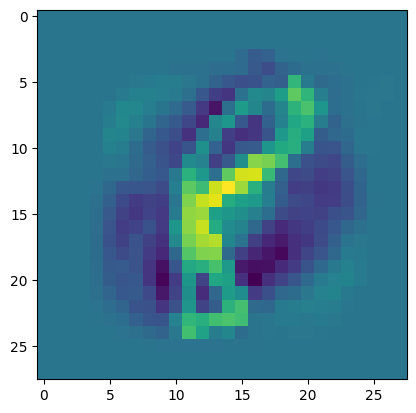

0.9728761514841351


In [4]:
train_data, train_labels, validation_data, validation_labels, test_data, test_labels = helper()
# ques1_a(train_data, train_labels, validation_data, validation_labels, 1000, 1)
# ques1_b(train_data, train_labels, validation_data, validation_labels, 1000, 0.725)
# ques1_c(train_data, train_labels, 0.725, math.pow(10, -4), 20000)
# print(ques1_d(train_data, train_labels, test_data, test_labels, 0.725, math.pow(10, -4), 20000))
# ques2_a(train_data, train_labels, validation_data, validation_labels, 1000)
print(ques2_b(train_data, train_labels, math.pow(10, -5), test_data, test_labels, 20000))
#ques2_c(train_data, train_labels, 20000, math.pow(10, -5))